In [1]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import graspologic as gl

/Users/thomasathey/Documents/shavit-lab/celegans/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get the current working directory
path = Path.cwd()
path_syncounts = path / "data" / "41586_2021_3778_MOESM4_ESM.xlsx"

# Format matrix of adult connectome
Rows are post synaptic, columns are pre

In [3]:
# read in the data
df = pd.read_excel(path_syncounts, sheet_name="Dataset8", header=2)
# remove first row
df = df.iloc[1:]
# remove the first column
df = df.iloc[:,1:]

#name the first column "neuron type"
df.columns = ["neuron type"] + list(df.columns[1:])
# name the second column "neuron name"
df = df.rename(columns={df.columns[1]: "neuron name"})

# if neuron type is nan, copy the previous neuron type
df["neuron type"] = df["neuron type"].fillna(method='ffill')

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_98261/3054718489.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


In [4]:
# assert that all neuron names are unique
row_names = df["neuron name"]
col_names = df.columns[2:]

assert row_names.nunique() == len(row_names)
assert col_names.nunique() == len(col_names)



In [5]:
# for neuron type, map Sensory to Sens.
df["neuron type"] = df["neuron type"].str.replace("Sensory", "Sens.")
df["neuron type"] = df["neuron type"].str.replace("Motor", "Mot.")
df["neuron type"] = df["neuron type"].str.replace("Inter", "Inter.")
df["neuron type"] = df["neuron type"].str.replace("Modulatory", "Mod.")
df["neuron type"] = df["neuron type"].str.replace("Motor", "Mot.")

In [6]:
df

,neuron type,neuron name,ADFL,ADFR,ADLL,ADLR,AFDL,AFDR,ALML,ALMR,...,PVNL,PVNR,PVQL,PVQR,RICL,RICR,RID,RIS,RMGL,RMGR
1,Sens.,ADFL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sens.,ADFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sens.,ADLL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sens.,ADLR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Sens.,AFDL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,Other,GLRDR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,Other,GLRL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,Other,GLRR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Other,GLRVL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Networkx object

In [7]:
G = nx.DiGraph()

# add edges
for i, row in df.iterrows():
    # iterate through the entries of row
    post = row["neuron name"]
    for pre, val in row.items():
        if pre not in ["neuron type", "neuron name"] and val > 0:
            G.add_edge(pre, post, weight=val)
    


# add neuron types
for i, row in df.iterrows():
    neuron_name = row["neuron name"]
    neuron_type = row["neuron type"]
    # if neuron name is not in the graph, add it
    if neuron_name not in G.nodes:
        G.add_node(neuron_name)
    G.nodes[neuron_name]["neuron type"] = neuron_type
    

# Graspologic plotting

In [ ]:
# remove all nodes that have neuron type equal to Muscle\
muscle_nodes = [n for n in G.nodes if G.nodes[n]["neuron type"] == "Muscle"]
G.remove_nodes_from(muscle_nodes)

A = nx.adjacency_matrix(G).todense()
neuron_types = [G.nodes[n]["neuron type"] for n in G.nodes]

# # permmute A and neuron_types so Mod. neurons come before Motor neurons
# perm = [i for i in range(len(neuron_types)) if neuron_types[i] != "Mod."]
# perm += [i for i in range(len(neuron_types)) if neuron_types[i] == "Mod."]
# A = A[perm,:][:,perm]
# neuron_types = [neuron_types[i] for i in perm]




## Compute average weights between communities

In [22]:
# for every combination of neuron types, get the number of edges between them
edges = []
for i in range(len(neuron_types)):
    for j in range(len(neuron_types)):
        if i != j:
            edges.append((neuron_types[i], neuron_types[j], A[i,j]))
edges = pd.DataFrame(edges, columns=["source", "target", "weight"])

# get the number of edges between each neuron type
edges = edges.groupby(["source", "target"]).mean().reset_index()

edges

,source,target,weight
0,Inter.,Inter.,0.603594
1,Inter.,Mod.,0.124608
2,Inter.,Mot.,0.389610
3,Inter.,Other,0.030303
4,Inter.,Sens.,0.104895
5,Mod.,Inter.,0.357367
6,Mod.,Mod.,0.220443
7,Mod.,Mot.,0.212644
8,Mod.,Other,0.080460
9,Mod.,Sens.,0.125199


## Check that adjacency is structured pre->post

In [16]:
# get the first edge
edges = list(G.edges(data=True))
edge = edges[0]

# get the node indices of the edge
pre = list(G.nodes).index(edge[0])
post = list(G.nodes).index(edge[1])

# double check that A[pre, post] is the same as edge[2]["weight"]
assert A[pre, post] == edge[2]["weight"]

## Plot

<Axes: title={'center': 'Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)'}>

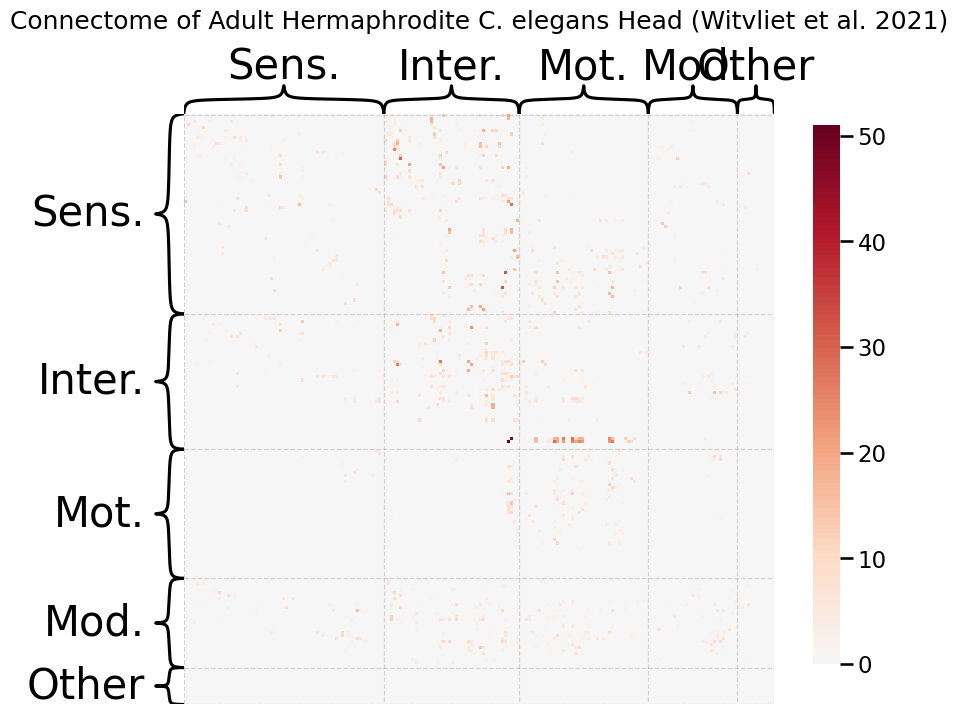

In [9]:
# use gl.plot.heatmap to plot the adjacency matrix and make the figure size 20x20
#fig, ax = plt.subplots(figsize=(20, 20))


title = "Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)"

gl.plot.heatmap(A, inner_hier_labels=neuron_types, sort_nodes=False, title=title)#, ax=ax)



<Axes: title={'center': 'Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)'}>

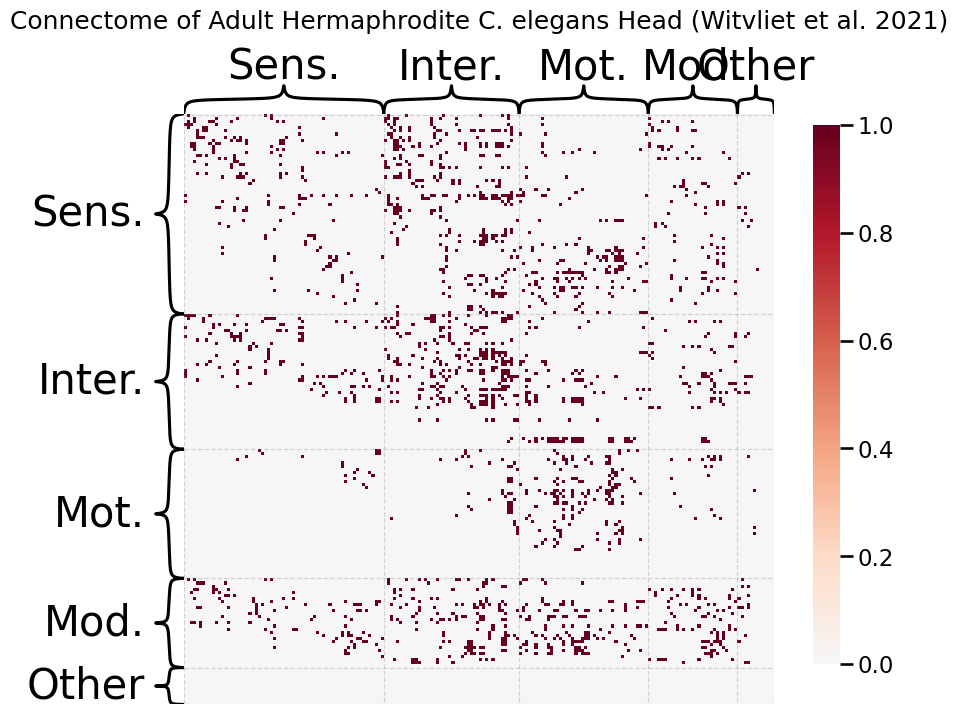

In [17]:
# use gl.plot.heatmap to plot the adjacency matrix and make the figure size 20x20
#fig, ax = plt.subplots(figsize=(20, 20))


title = "Binarized of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)"

gl.plot.heatmap(A>0, inner_hier_labels=neuron_types, sort_nodes=False, title=title)#, ax=ax)

